<a href="https://colab.research.google.com/github/jayqbe/python_trading_projects/blob/main/Marek_CSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INSIDE BAR BREAKOUT**

------------
Version: 0.1

Prepared by: Jakub Kozlowski, Marek Grochowski

Maintained by: not maintained

---------



## **Description**

In this Python notebook we analyze viability of Inside Bar formation as a legitimate high-resolution high-frequency trading strategy. The strategy aims to monetize on increases in volatility of the instrument following a period of decreasing volatility.

An Inside Bar is a formation of two consecutive bars, where the second bar is fully enclosed within the range of the previous bar (i.e. the second bar's high is lower than previous bar's high and, similarly, the second bar's low is higher than the first bar's low).

The premise of the strategy is to open a long position when market breaks above the high of an inside bar. Conversely, when the price falls below an inside bar's low, a short position should be opened.

## **Import required packages**

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

## **Analysis**

#### **Step 1: Mount Google drive and load data**

In [2]:
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/IB colab notebooks/es-1m.csv", header=None,
                 sep=";", names=["Date", "Time", "Open", "High", "Low", "Close", "Volume"])

Mounted at /content/drive


#### **Step 2: Pre-process data**

I. Convert 'Date' and 'Time' columns into datetime type and merge them into
one 'Datetime' column. Finally, set it as DataFrame's index and remove redundant columns.

In [3]:
df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")

df.set_index("Datetime", inplace=True)

df.drop(columns=["Date", "Time"], inplace=True)

II. Select entire 2021, delete original DataFrame to save memory and inspect new DataFrame for NaN values and gaps in timeline.

In [4]:
df_2021 = df[(df.index >= "2021-01-01") & (df.index <= "2021-12-31")]
del df

In [5]:
df_2021.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352381 entries, 2021-01-03 17:00:00 to 2021-12-31 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    352381 non-null  float64
 1   High    352381 non-null  float64
 2   Low     352381 non-null  float64
 3   Close   352381 non-null  float64
 4   Volume  352381 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 16.1 MB


In [6]:
(df_2021.index[1:] - df_2021.index[:-1]).value_counts()

0 days 00:01:00    351882
0 days 01:01:00       201
0 days 00:16:00       121
0 days 00:02:00       113
2 days 01:01:00        48
0 days 05:01:00         6
0 days 00:03:00         3
0 days 00:04:00         1
0 days 00:05:00         1
2 days 08:46:00         1
0 days 00:10:00         1
2 days 04:46:00         1
3 days 01:01:00         1
Name: Datetime, dtype: int64

No NaNs are present in DataFrame but there are many gaps due to weekends, holidays, etc. To effectively work with time series data it is advisable to fill in the gaps. We do this with the code below but to avoid influencing the strategy by data from non-trading days we mark those days where trading was not open.

III. Reindex the DataFrame to eliminate gaps and create a column 'Market closed' which indicates that there was no trading during this perdiod.

In [7]:
df_2021 = df_2021.reindex(pd.date_range(df_2021.index[0], df_2021.index[-1], freq="1min"), method=None)

df_2021["Market closed"] = df_2021["Open"].isna()

"""Print gaps to verify if data was filled in correctly"""
(df_2021.index[1:] - df_2021.index[:-1]).value_counts()

0 days 00:01:00    520260
dtype: int64

IV. Although the strategy could be applied to any resolution of bars we decided to focus on 15-minute intervals. In the code below we aggregate 1-minute bars of the original data set into 15-minute bars. Note that this is done only for 'High', 'Low' and 'Volume' columns, although it could be extended over the other numerical data.

In [8]:
df_2021.loc[:, "Resampled_High"] = df_2021["High"].resample("15T").max()
df_2021.loc[:, "Resampled_Low"] = df_2021["Low"].resample("15T").min()
df_2021.loc[:, "Resampled_Volume"] = df_2021["Volume"].resample("15T").sum()
df_2021 = df_2021.ffill()

#### **Step 3: Identify Inside Bar formations**

I. We create a column named 'Inside_bar' which holds a boolean for each 1-minute bar which is within the 15-minute Inside Bar. Then we shift values of 'Inside_bar' column along with respective resampled columns in order to avoid a look-ahead bias in our data. 

Note that we would only know if a bar is an Inside Bar at the end of the last 1-minute bar of every 15-minute period (e.g. at 14th, 29th, 44th and 59th minutes of every hour).

In [9]:
df_2021["Inside_bar"] = (df_2021["Resampled_High"].shift(15) > df_2021["Resampled_High"]) & \
(df_2021["Resampled_Low"].shift(15) < df_2021["Resampled_Low"])

df_2021[["Resampled_High", "Resampled_Low", "Inside_bar", "Resampled_Volume"]] = df_2021[
    ["Resampled_High", "Resampled_Low", "Inside_bar", "Resampled_Volume"]].shift(15).shift(-1)

II. We're getting index values of final 1-minute bars of each 15-min Inside Bar.

In [10]:
idx = df_2021[df_2021.index.minute.isin([14, 29, 44, 59]) & df_2021["Inside_bar"] & ~df_2021["Market closed"]].index

III. We're adding additional columns which will aid with the analysis:

- bar size (range) expressed in number of ticks
- size of take profit and stop loss in number of ticks
- ditances of consecutive 1-min bars highs and lows from current Inside Bar's high and low 

In [11]:
ticksize = .25
fibo = .169

df_2021["High_next_high_delta"] = (df_2021["High"] - df_2021["Resampled_High"]) / ticksize
df_2021["High_next_low_delta"] = (df_2021["Low"] - df_2021["Resampled_High"]) / ticksize
df_2021["Low_next_low_delta"] = (df_2021["Low"] - df_2021["Resampled_Low"]) / ticksize
df_2021["Low_next_high_delta"] = (df_2021["High"] - df_2021["Resampled_Low"]) / ticksize
df_2021["Bar_size"] = (df_2021["Resampled_High"] - df_2021["Resampled_Low"]) / ticksize
df_2021["Take_profit_size"] = (np.round(
    (df_2021["Resampled_High"] + df_2021["Bar_size"] * ticksize * fibo) * (1 / ticksize)
) / (1 / ticksize) - df_2021["Resampled_High"]) / ticksize
df_2021["Stop_loss_size"] = np.round(df_2021["Bar_size"] / 2)

#### **Step 4: Visualize data**

In [12]:
sns.set_theme(style="darkgrid", palette="deep")

###### I. Inside Bar size distribution

First we wanted to see how the size of Inside Bars is distributed. As the strategy relies on setting take profit/stop loss levels based on *Fibonacci extensions and retracements*, there is a size of a bar below which rounding to the nearest tick size distorts those price levels (i.e. take profit 1 tick above Inside Bar's high might fall far above the extension of .169).

Text(0, 0.5, 'Relative frequency [%]')

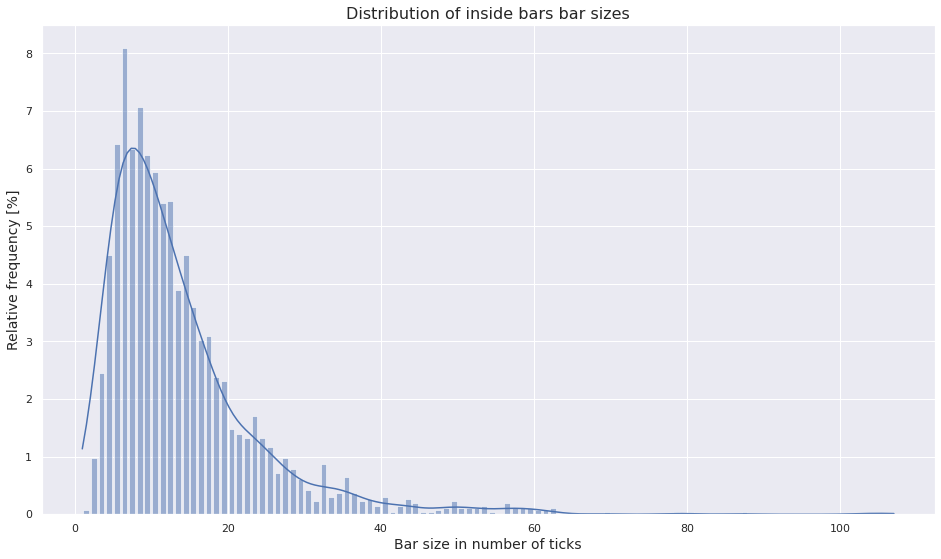

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

sns.histplot(
    data=df_2021.loc[idx],
    x="Bar_size",
    bins=[x for x in range(1, 100, 1)],
    stat="percent",
    kde=True,
    ax=ax,
    shrink=.75
)

ax.grid(True)
ax.set_title("Distribution of inside bars bar sizes", fontsize=16)
ax.set_xlabel("Bar size in number of ticks", fontsize=14)
ax.set_ylabel("Relative frequency [%]", fontsize=14)

*We determined the threshold to be 10 ticks, which eliminates around 35% of all Inside Bars from being eligible entry points.*

###### II. Liquidity

Next we give concern to liquidity depth throughout the trading day, in and outside the regular trading hours.

There is a clear and substantial difference between the traded volume in and outside regular trading hours, with the former being **greater by a factor between 3 and 10** for both the mean and median.

Though with appropriate position sizing, lower volums might not preclude the strategy from being implemented, lower volume might be correspondent to other effects that could impede the implementation. As we showcase in one of the next sections this is the case.

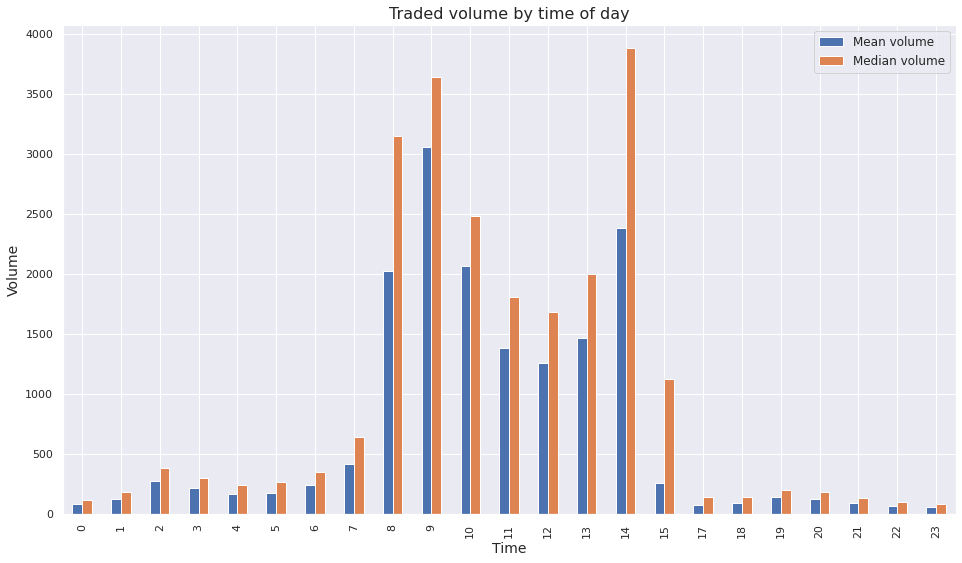

In [14]:
ax = df_2021[~df_2021["Market closed"]]["Volume"].groupby(
    by=df_2021[~df_2021["Market closed"]].index.hour).agg(
        {"median", "mean"}).plot(
            kind="bar",
            grid=True,
            figsize=(16,9)
            )

ax.set_title("Traded volume by time of day", fontsize=16)
ax.set_ylabel("Volume", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
ax.legend(["Mean volume", "Median volume"], fontsize=12)

###### III. Opportunities vs time of day

We then continued our analysis to probe between the time of trading day and number of Inside Bar formations. Values in the chart are aggregated over the entire year.

Two one-hour periods stand out from the rest of the graph, namely 2 and 3 pm with a substantially lower and higher number of Inside Bars respectively.

Text(0.5, 0, 'Time')

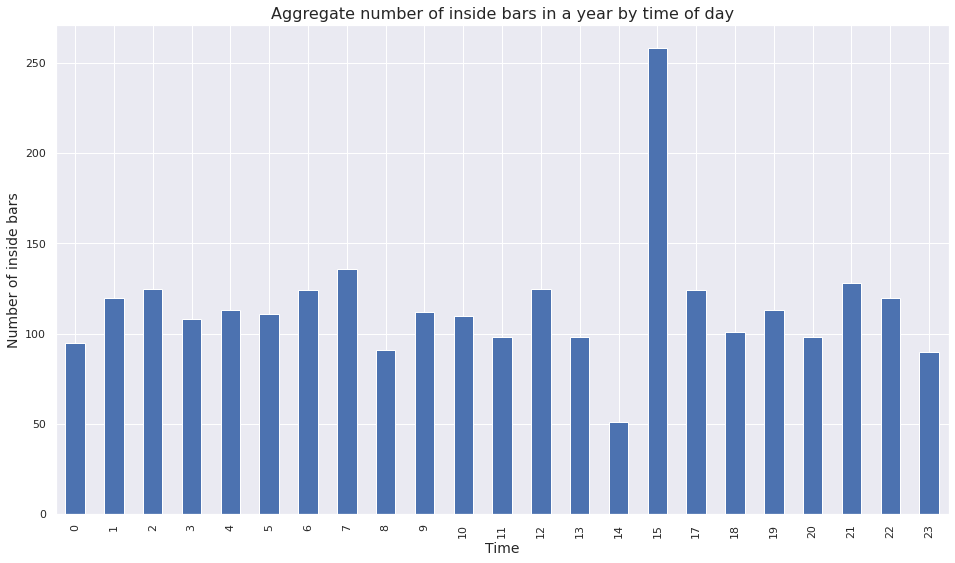

In [15]:
ax = df_2021.loc[idx].groupby(by=idx.hour).count()["Open"].plot(
    kind="bar",
    grid=True,
    figsize=(16,9)
)

ax.set_title("Aggregate number of inside bars in a year by time of day", fontsize=16)
ax.set_ylabel("Number of inside bars", fontsize=14)
ax.set_xlabel("Time", fontsize=14)

To verify if the effect seen above is systematic we increase resolution of the aggregate from one year to twelve months. As you can see, the one-hour period starting 3 pm has the most number of Inside Bar in each monthly aggregate. Conversely, the one-hour period starting 2 pm has the least number of formations in four months and shares the lead in this category with other periods in other four months. This might suggest a peculiar effect of volatility during these two hours of trading.

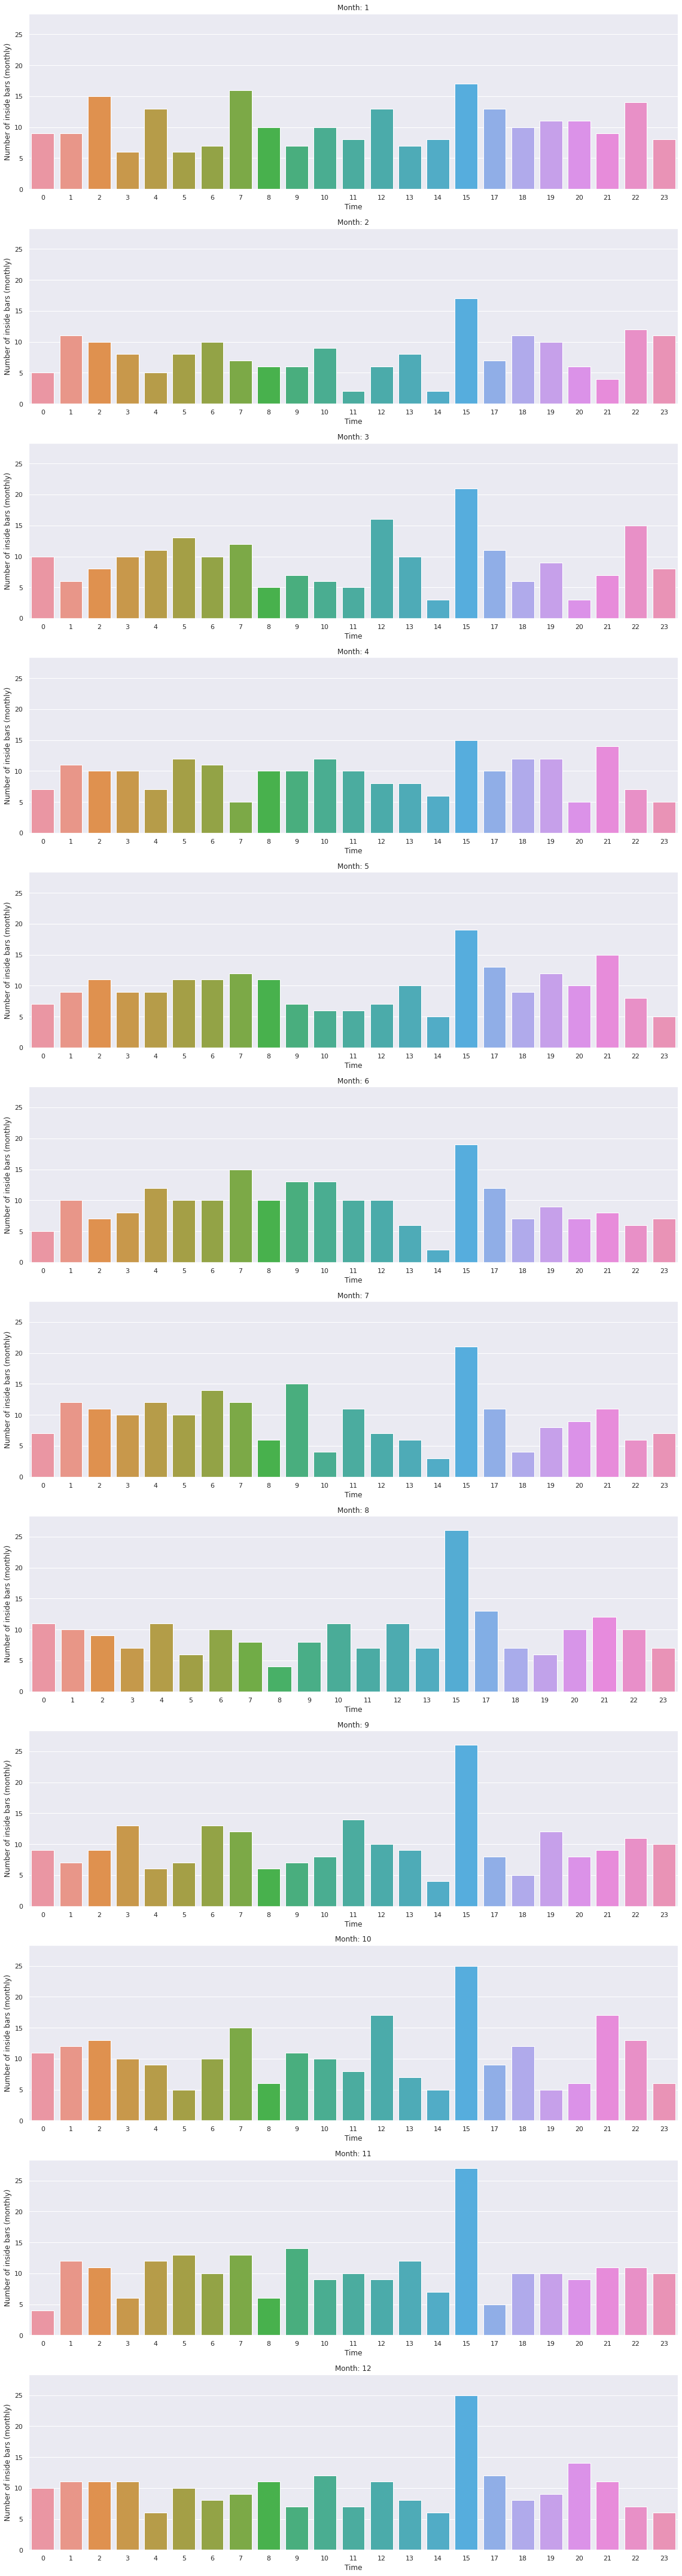

In [16]:
df_2021["Month"] = df_2021.index.month

fig, ax = plt.subplots(12, 1, figsize=(16, 5*12), sharey=True, tight_layout=True)

for month in df_2021["Month"].unique():
    
    p = sns.barplot(
        data=df_2021.loc[idx[idx.month == month]].groupby(
            by=df_2021.loc[idx[idx.month == month]].index.hour).count().reset_index(),
        x="index",
        y="Open",
        ax=ax[month-1]
    )
    
    p.set_xlabel("Time", fontsize=12)
    p.set_ylabel("Number of inside bars (monthly)", fontsize=12)
    p.set_title(f"Month: {month}")

*Note that one-hour period starting 4 pm is missing entirely as the market is closed then*

###### IV. Bar size vs time of day

Continuing with the time-of-day theme, we investigate further its influence on Inside Bar size. Although the effect is not as pronounced as with traded volume, the chart below shows that during ragular trading hours the size is larger than outside those hours.

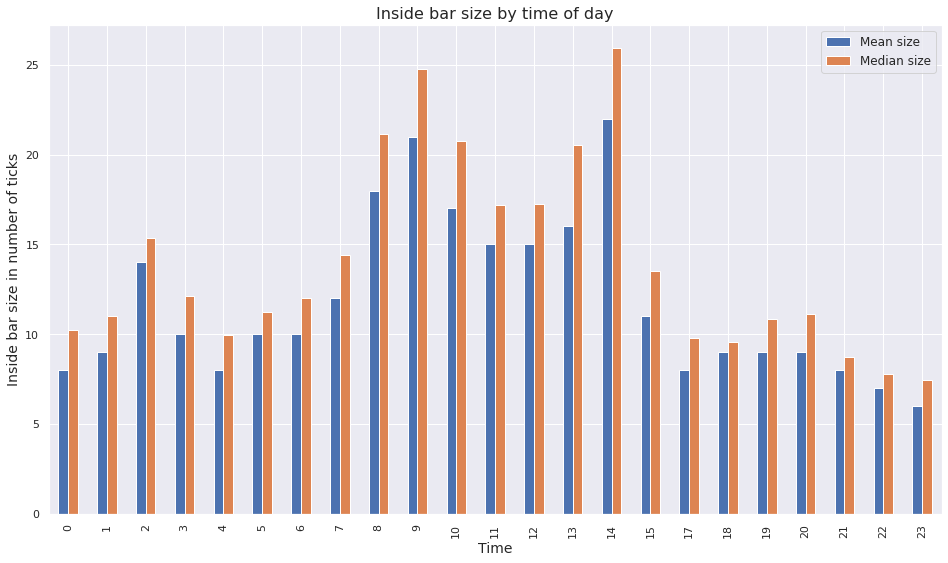

In [17]:
ax = df_2021.loc[idx, "Bar_size"].groupby(by=idx.hour).agg({"median", "mean"}).plot(
    kind="bar",
    grid=True,
    figsize=(16,9)
)

ax.set_title("Inside bar size by time of day", fontsize=16)
ax.set_ylabel("Inside bar size in number of ticks", fontsize=14)
ax.set_xlabel("Time", fontsize=14)
ax.legend(["Mean size", "Median size"], fontsize=12)

###### V. Risk vs reward

We now switch our attention to risk/reward profile of the strategy in an effort to calculate potential gains and losses and derive breakeven win rate.

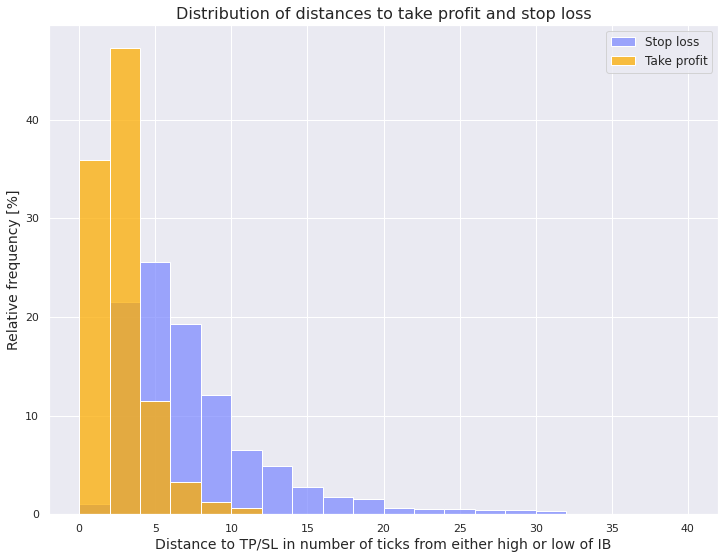

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9))

p1 = sns.histplot(
    data=df_2021.loc[idx],
    x="Stop_loss_size",
    bins=[x for x in range(0, 42, 2)],
    stat="percent",
    ax=ax,
    color=["#808cff"]
)

p2 = sns.histplot(
    data=df_2021.loc[idx],
    x="Take_profit_size",
    bins=[x for x in range(0, 42, 2)],
    stat="percent",
    ax=ax,
    color=["#fcad03"]
)

ax.set_title("Distribution of distances to take profit and stop loss", fontsize=16)
ax.set_ylabel("Relative frequency [%]", fontsize=14)
ax.set_xlabel("Distance to TP/SL in number of ticks from either high or low of IB", fontsize=14)
ax.legend(["Stop loss", "Take profit"], fontsize=12)

In thoery we could calculate the ratio of take profit and stop loss levels to get the win rate, however because the product has a minimum tick size of 25 cents and we use an extension of .169 to calculate take profit price, the result might be inaccurate.

This is further supported by the scatterplot below, where different TP levels take multiple values of SL levels and vice versa.

Text(0.5, 0, 'Take profit size in ticks')

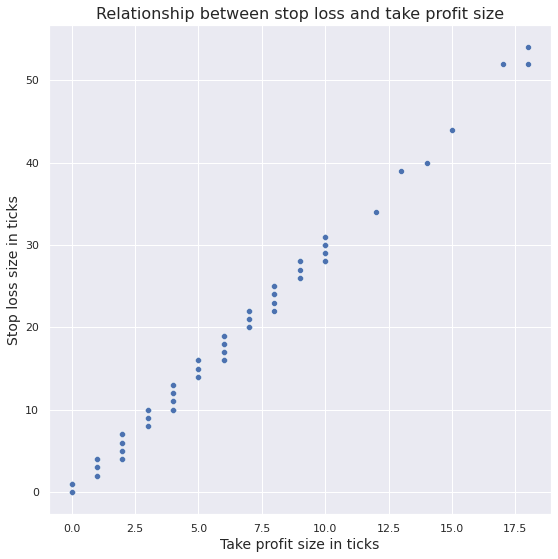

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))

p1 = sns.scatterplot(
    x=df_2021.loc[idx]["Take_profit_size"],
    y=df_2021.loc[idx]["Stop_loss_size"],
    ax=ax
)

ax.set_title("Relationship between stop loss and take profit size", fontsize=16)
ax.set_ylabel("Stop loss size in ticks", fontsize=14)
ax.set_xlabel("Take profit size in ticks", fontsize=14)

To account for this, we calculate the dollar value of all potential gains as well as potential losses and then derive win rate from a simple system of linear algebra equations.

In [20]:
dollar_profit, dollar_loss = (df_2021.loc[idx, ["Take_profit_size", "Stop_loss_size"]].sum() * ticksize * 50)

A = np.array([[dollar_profit, -dollar_loss], [1, 1]])
b = np.array([0, 1])

win_rate, loss_rate = np.linalg.solve(A, b)

Unfortunately, we can't stop there as commissions charged for each transaction will decrease potential gains and increase potential losses. We repeat the calculation below to accomodate for this.

In [21]:
commission = 2.15

dollar_profit_comm = dollar_profit - len(idx) * commission * 2
dollar_loss_comm = dollar_loss + len(idx) * commission * 2

A = np.array([[dollar_profit_comm, -dollar_loss_comm], [1, 1]])
b = np.array([0, 1])

win_rate_comm, loss_rate_comm = np.linalg.solve(A, b)

In [22]:
print(
    f"Theoretical breakeven win rate: {(1 - fibo / (fibo + .5)) * 100:.2f}%\n",
    f"Commission-less breakeven win rate: {win_rate * 100:.2f}%\n",
    f"Actual breakeven win rate: {win_rate_comm * 100:.2f}%"
)

Theoretical breakeven win rate: 74.74%
 Commission-less breakeven win rate: 74.32%
 Actual breakeven win rate: 78.06%


###### VI. Formation validation

This strategy will only execute when a formation is validated by the market, that is when the price of instument will venture above the high of the identified Inside Bar or below its low. Therefore, it is important to see how the prices develop after a breakout.

The code below locates breakouts to the upside and to the downside and records how many minutes after the close of Inside Bar this happens.

In [23]:
breakout_up = {}
breakout_down = {}

for i in idx[:-1]:
    
    for j in range(1, 15):
        
        if df_2021.loc[i + timedelta(minutes=j), "High_next_high_delta"] > 0:
            breakout_up[i] = j
            break
    
    for j in range(1, 15):
        
        if df_2021.loc[i + timedelta(minutes=j), "Low_next_low_delta"] < 0:
            breakout_down[i] = j
            break

print(
    f"Number of breakouts above Inside Bar: {len(breakout_up)}\n",
    f"Number of breakouts below Inside Bar: {len(breakout_down)}"
    )

Number of breakouts above Inside Bar: 1380
 Number of breakouts below Inside Bar: 1222


We now visualize the distribution of above and can observe that around half of all Inside Bars are validated (i.e. there's up or down breakout) within 4 minutes from the finished 15-minute bar.

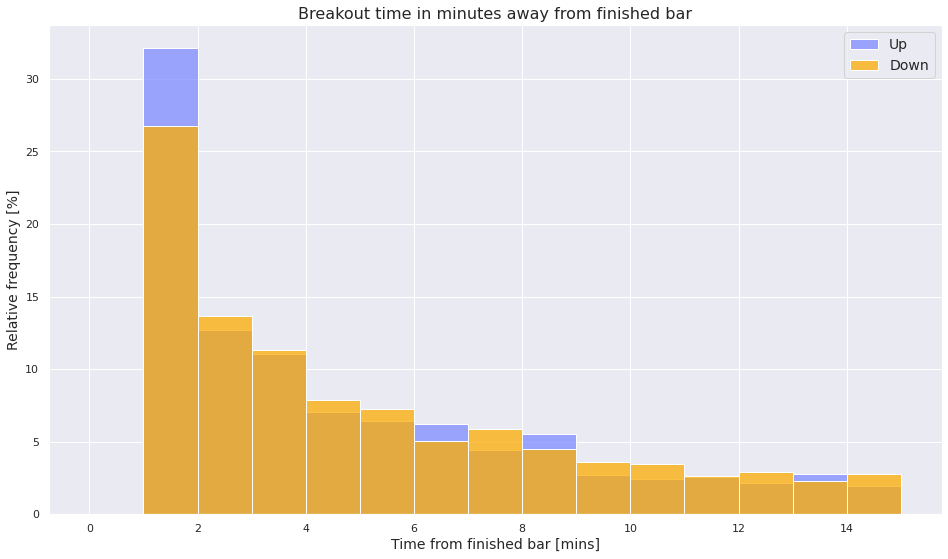

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))

p1 = sns.histplot(
    list(breakout_up.values()),
    ax=ax,
    bins=[x for x in range(0,16)],
    alpha=.75,
    color=["#808cff"],
    stat="percent"
)
p2 = sns.histplot(
    list(breakout_down.values()),
    ax=ax,
    bins=[x for x in range(0,16)],
    alpha=.75,
    color=["#fcad03"],
    stat="percent"
)

ax.set_title("Breakout time in minutes away from finished bar", fontsize=16)
ax.set_ylabel("Relative frequency [%]", fontsize=14)
ax.set_xlabel("Time from finished bar [mins]", fontsize=14)
ax.legend(["Up", "Down"], fontsize=14)

###### VII. What happens following a breakout

In these next sections we investigate behaviour of the market after price of an instrument has broken out either above or below the Inside Bar range. To that end we look at distributions of distances from highs and lows of consecutive 1-min bars to the high and low of latest Inside Bar.

We now plot distributions of distances between highs and lows of consecutive 1-min bars and high and low of preceding Inside Bar. We do this over the period of subsequent 10 minutes.

Text(0.5, 1.01, 'Distribution of deltas between IB high/low and consecutive highs/lows')

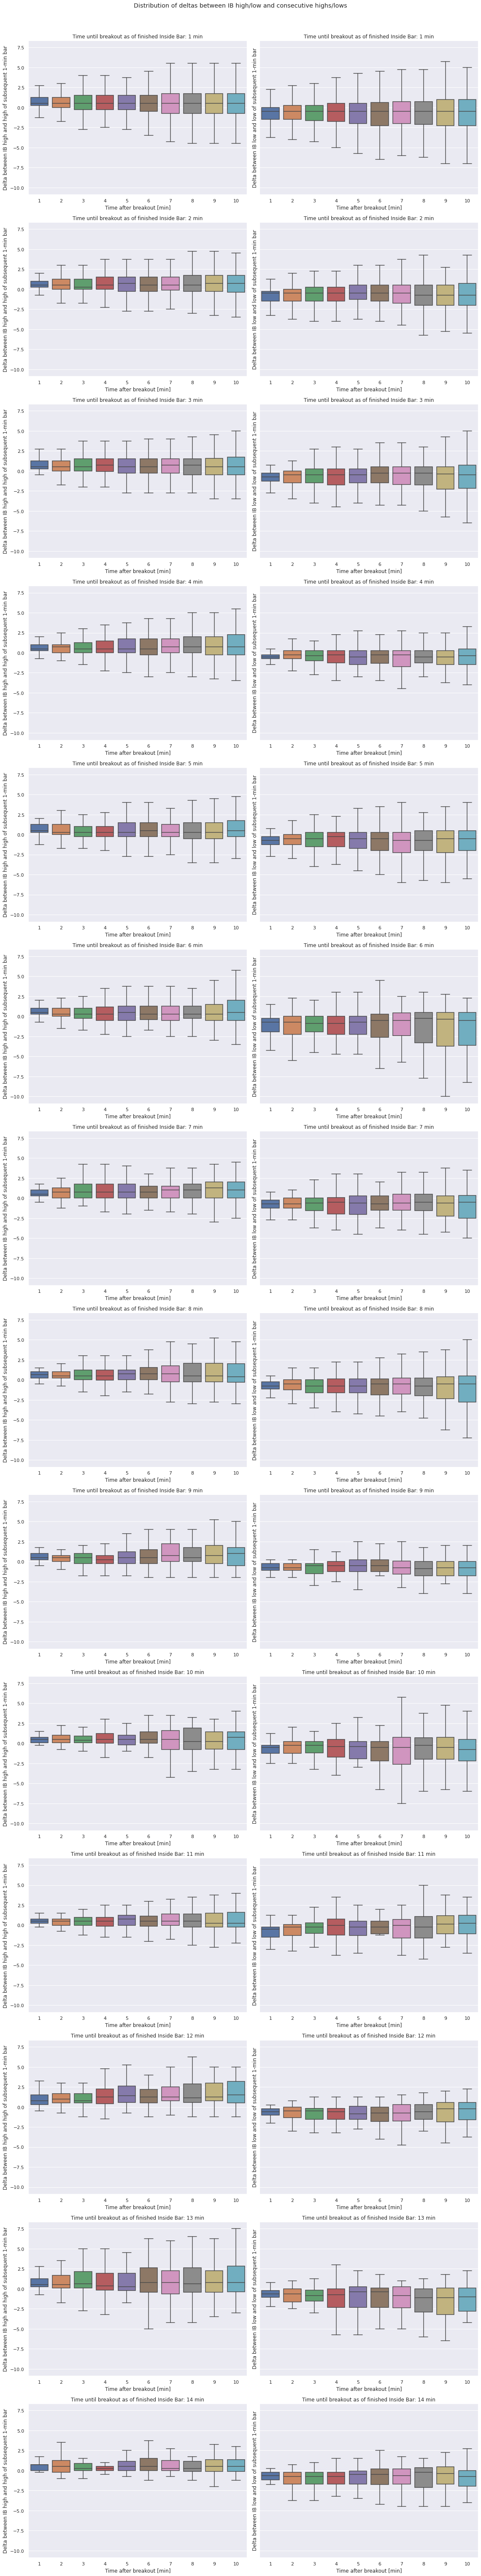

In [44]:
fig, ax = plt.subplots(14, 2, figsize=(16, 6*14), sharey=True, tight_layout=True)

for j in range(1, 15):
  base_index_up = [k + timedelta(minutes=v) for k, v in zip(
      list(breakout_up.keys()),list(breakout_up.values())) if v == j]

  data_up = df_2021.copy()
  data_up["Time delta"] = ""
  data_up["High delta"] = ""

  base_index_down = [k + timedelta(minutes=v) for k, v in zip(
      list(breakout_down.keys()),list(breakout_down.values())) if v == j]

  data_down = df_2021.copy()
  data_down["Time delta"] = ""
  data_down["High delta"] = ""
  
  for t in range(1, 11):
    new_indx_up = [i + timedelta(minutes=t) for i in base_index_up]
    ib_high = data_up.loc[[i - timedelta(minutes=t) for i in new_indx_up], "Resampled_High"]
    data_up.loc[new_indx_up, "Time delta"] = t
    data_up.loc[new_indx_up, "High delta"] = data_up.loc[new_indx_up, "High"] - ib_high.to_list()

    new_indx_down = [i + timedelta(minutes=t) for i in base_index_down]
    ib_low = data_down.loc[[i - timedelta(minutes=t) for i in new_indx_down], "Resampled_Low"]
    data_down.loc[new_indx_down, "Time delta"] = t
    data_down.loc[new_indx_down, "Low delta"] = data_up.loc[new_indx_down, "Low"] - ib_low.to_list()
  
  data_up.drop(index=data_up[data_up["Time delta"] == ""].index, inplace=True)
  data_down.drop(index=data_down[data_down["Time delta"] == ""].index, inplace=True)
    
  sns.boxplot(
      data=data_up,
      x="Time delta",
      y="High delta",
      ax=ax[j-1][0],
      showfliers=False
  )

  ax[j-1][0].set_title(f"Time until breakout as of finished Inside Bar: {j} min")
  ax[j-1][0].set_ylabel("Delta between IB high and high of subsequent 1-min bar", fontsize=12)
  ax[j-1][0].set_xlabel("Time after breakout [min]", fontsize=12)
    
  sns.boxplot(
      data=data_down,
      x="Time delta",
      y="Low delta",
      ax=ax[j-1][1],
      showfliers=False
  )

  ax[j-1][1].set_title(f"Time until breakout as of finished Inside Bar: {j} min")
  ax[j-1][1].set_ylabel("Delta between IB low and low of subsequent 1-min bar", fontsize=12)
  ax[j-1][1].set_xlabel("Time after breakout [min]", fontsize=12)

fig.suptitle("Distribution of deltas between IB high/low and consecutive highs/lows", y=1.01)

Two patterns emerge from the above:

1.   The longer the time until breakout, the larger the proportion of the distribution seems to fall above 0, suggesting a better chance of obtainig profit from the transaction.
2.   The longer the time after breakout, the wider the dispersion and the higher the risk of closing the trade with a loss.